# Spooky Author - LDA Approach

## Goal:

    The goal of this challenge is to predict the author of excerpts from horror stories by Edgar Allan Poe, Mary Shelley, and HP Lovecraft. We will try to accomplish this task, using LDA to predict author's writing styles. 

In [50]:
# First load the training dataset using pandas
import pandas as pd

training_dataset = pd.read_csv("train.csv")

all_text = training_dataset["text"].values

In [17]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/veronica/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/veronica/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Natural Language Processing:

In [18]:
import nltk
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
import re

def text_processing(text, is_corpus = False):
    """
        if is_corpus = True: 
            text is a giant list of list containing the entire dataset
        if is_corpus = False:
            text is only a single list, so no need to iterate over it
    """
    
    # for every sublist in text, do all the necessary text pre-processing steps
    # text_processing includes tokenization, stopwords removal and lemmatization
    if is_corpus:
        text_list = []
        for line in text:
            line = tokenize(line)
            line = stopwords_removal(line)
            line = lemmatize(line)
            text_list.append(line)
        return text_list
    else:
        text = tokenize(text)
        text = stopwords_removal(text)
        text = lemmatize(text)
        return text

#### Tokenization 
    Break entire corpus into seperate individual words

In [19]:
def tokenize(text):
    """
        nltk.word_tokenize will tokenize every word 
        re.sub will remove all non alpha-numeric characters and lowercase every word
        filtering will remove empty lists
        returned the tokenized text
    """
    tokenized = nltk.word_tokenize(text)
    tokenized = [re.sub(r"\W+", "", t).lower() for t in tokenized]
    tokenized = list(filter(lambda t: t.isalnum(), tokenized))
    return tokenized

####  Lemmatization
    Rather than Porter Stemming, which chops each word into its root form. Lemmatization breaks each word into its dictionary form. 

In [20]:
def lemmatize(text):
    """
        convert each word in text into its dictionary form
        return the dictionary form list
    """
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in text]
    return lemmatized

#### Stopword Removal
    Remove all words that appear way too often, use nltk to select what are stopwords

In [21]:
def stopwords_removal(text):
    """
        remove all stopwords
        return list with all stopwords removed
    """
    stopwords = nltk.corpus.stopwords.words("english")
    stopwords_removed = list(filter(lambda st: st not in stopwords, text))
    return stopwords_removed

#### Process Text
    Call the text_processing function, which calls all other functions

In [22]:
# pre-process all text
all_processed_text = text_processing(all_text, is_corpus = True)
print(all_text[:5])
print()
print(all_processed_text[:5])

['This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'
 'It never once occurred to me that the fumbling might be a mere mistake.'
 'In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.'
 'How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.'
 'Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.']

[['process', 'however', 'afforded', 'mean', 'ascertaining', 'dimension', 'dungeon', 'might', 'ma

## LDA:

    Main components LDA model takes in are the entire corpus as a bag of words, the number of topics to create and document-term matrix

In [23]:
from gensim.corpora import Dictionary
from gensim import models

def create_dictionary(training_dataset):
    """
        Mapping unique integer id's to words
    """
    dictionary = Dictionary(training_dataset)
    return dictionary

def create_corpus_bow(dictionary, training_dataset):
    """
        Count of word occurrence for each word
    """
    corpus_bow = [dictionary.doc2bow(text) for text in training_dataset]
    return corpus_bow

def create_lda_model(corpus_bow, dictionary, num_topics):
    """
        Topic Model:
            passes - Number of passes through the corpus during training
            random_state - Select a random seed, elimate randomness
    """
    lda_model = models.ldamodel.LdaModel(corpus_bow, num_topics = num_topics, id2word = dictionary, passes = 10, random_state = 1500)
    return lda_model

### 1 LDA Model
    First create the dictionary (id2word) and corpus as bag of words.

In [24]:
dictionary_all = create_dictionary(all_processed_text)
corpus_bow_all = create_corpus_bow(dictionary_all, all_processed_text)

#### How Many Topics To Create?
    Before creating the topic model, we must figure out what is the best number of topics to create.
    Coherence is the measurement that is used to evaluate how well a topic model is created.
    Before I create the LDA model I will use for testing, I create multiple models with different number of topics 
    and calculate their coherence score
    

In [25]:
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.ldamodel.LdaModel(corpus = corpus, id2word = dictionary, num_topics = num_topics, passes = 10, random_state = 1500)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
"""
model_list, coherence_values = compute_coherence_values(dictionary = dictionary_all, corpus= corpus_bow_all, texts = all_processed_text, start=3, limit=25, step=3)
# Show graph
import matplotlib.pyplot as plt
limit=25; start=3; step=3;

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.title("Coherence Values", fontsize = 20)
plt.xlabel("Num Topics", fontsize = 15)
plt.ylabel("Coherence score", fontsize = 15)
plt.show()
"""

'\nmodel_list, coherence_values = compute_coherence_values(dictionary = dictionary_all, corpus= corpus_bow_all, texts = all_processed_text, start=3, limit=25, step=3)\n# Show graph\nimport matplotlib.pyplot as plt\nlimit=25; start=3; step=3;\n\nx = range(start, limit, step)\nplt.plot(x, coherence_values)\nplt.title("Coherence Values", fontsize = 20)\nplt.xlabel("Num Topics", fontsize = 15)\nplt.ylabel("Coherence score", fontsize = 15)\nplt.show()\n'

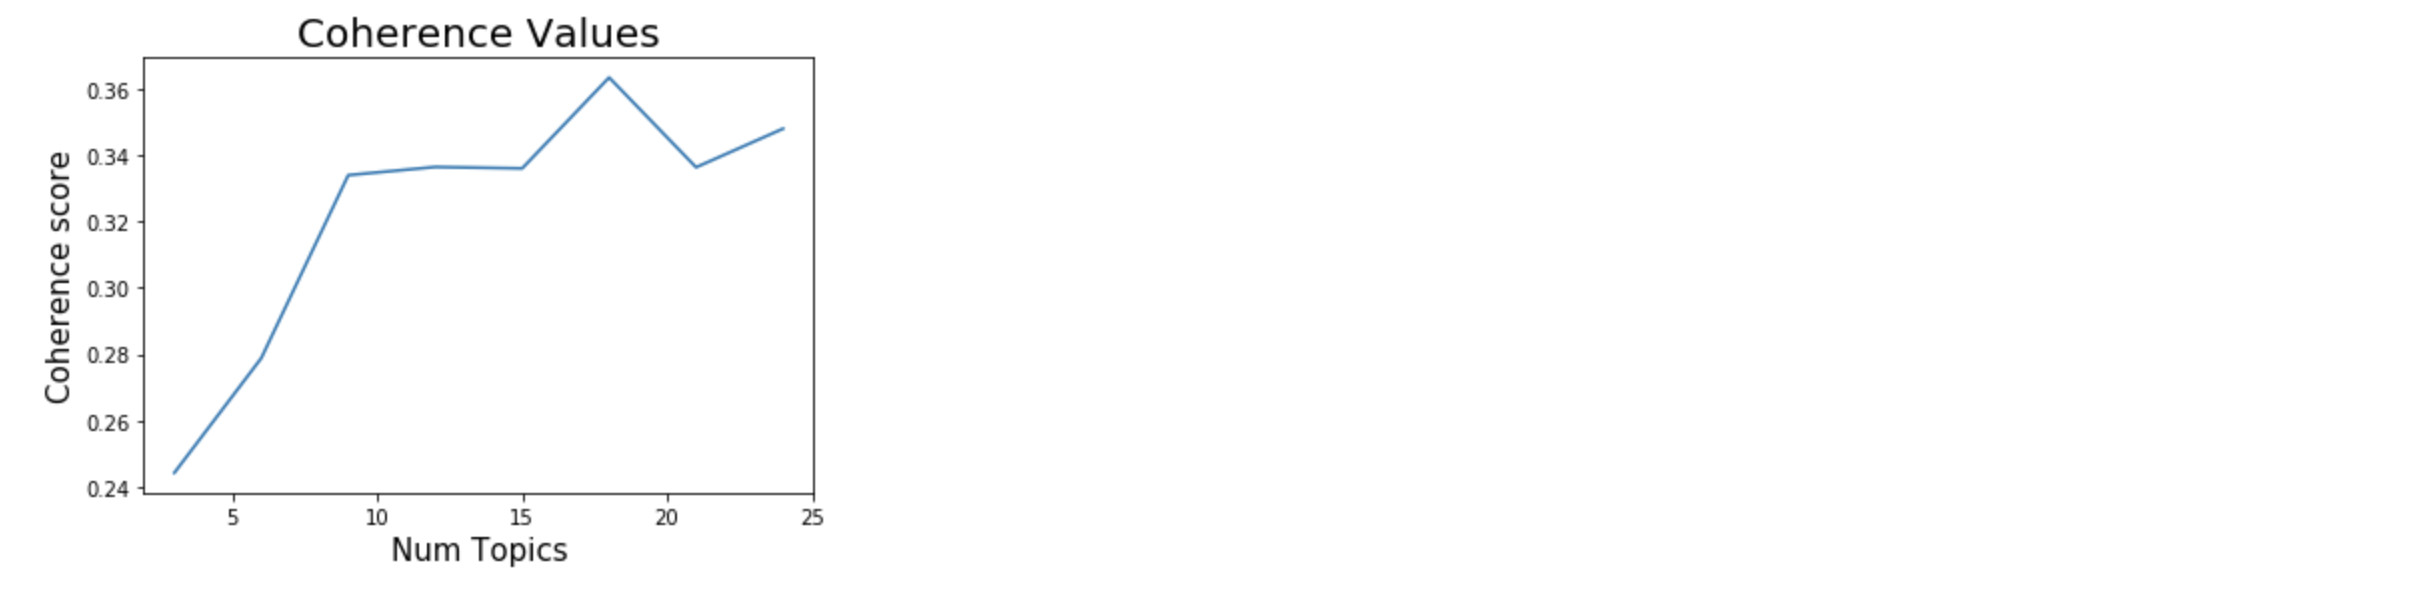

    The graph shows the coherence score increasing dramatically up until 9 topics. After 9 topics, the coherence 
    score does not change as drastically. Even though 18 topics has a higher coherence score, the difference between them is not much.
    9 topics would be a good choice because it has a fairly high coherence score without creating too many topics. The more topics that are 
    created the greater the likelihood of topics being intertwined with each other, which is something you should try to avoid. 

##### Create LDA Model Using 12 Topics

In [27]:
lda_model_all = create_lda_model(corpus_bow_all, dictionary_all, num_topics = 9)

    Compute coherence score of our model

In [28]:
# Compute Coherence Score
coherence_model_lda_all = CoherenceModel(model=lda_model_all, texts=all_processed_text, dictionary=dictionary_all, coherence='c_v')
coherence_lda_all = coherence_model_lda_all.get_coherence()
print('\nCoherence Score: ', coherence_lda_all)


Coherence Score:  0.3339417051776686


###### Print Topics

In [29]:
# Print topics that were create using LDA
print("Topics:")
for topic in lda_model_all.print_topics():
    print(topic)

Topics:
(0, '0.007*"one" + 0.007*"house" + 0.007*"wall" + 0.006*"foot" + 0.006*"street" + 0.005*"two" + 0.005*"stone" + 0.005*"window" + 0.005*"wind" + 0.005*"light"')
(1, '0.009*"thing" + 0.008*"one" + 0.008*"old" + 0.008*"like" + 0.007*"could" + 0.006*"man" + 0.005*"upon" + 0.005*"face" + 0.004*"see" + 0.004*"seen"')
(2, '0.010*"year" + 0.009*"day" + 0.007*"one" + 0.007*"first" + 0.006*"said" + 0.006*"raymond" + 0.006*"time" + 0.005*"two" + 0.005*"better" + 0.004*"home"')
(3, '0.010*"upon" + 0.010*"one" + 0.008*"would" + 0.007*"could" + 0.007*"life" + 0.006*"eye" + 0.006*"thought" + 0.006*"death" + 0.006*"word" + 0.005*"heart"')
(4, '0.009*"upon" + 0.006*"could" + 0.005*"yet" + 0.005*"saw" + 0.004*"night" + 0.004*"voice" + 0.004*"water" + 0.004*"even" + 0.003*"sound" + 0.003*"adrian"')
(5, '0.009*"door" + 0.006*"one" + 0.006*"upon" + 0.005*"open" + 0.005*"hand" + 0.005*"back" + 0.005*"within" + 0.005*"left" + 0.004*"room" + 0.004*"side"')
(6, '0.007*"human" + 0.005*"yet" + 0.005*"fou

###### Visualization

In [31]:
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_all, corpus_bow_all, dictionary_all, sort_topics = False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.259944 -0.008840       1        1   9.655801
1     -0.111623  0.010415       2        1  12.780738
2      0.053116 -0.194761       3        1  10.573683
3      0.075388  0.074170       4        1  17.543074
4      0.016367  0.145745       5        1  11.193128
5     -0.157563 -0.035269       6        1   8.969593
6      0.122981  0.161308       7        1   8.364182
7      0.110122  0.026087       8        1   9.601712
8      0.151155 -0.178855       9        1  11.318092, topic_info=     Category         Freq     Term        Total  loglift  logprob
term                                                              
425   Default   637.000000     said   637.000000  30.0000  30.0000
843   Default   318.000000     door   318.000000  29.0000  29.0000
156   Default   465.000000      say   465.000000  28.0000  28.0000
63    Default   414.000000     year   414.000000  27.0000  27.0000
1102  Default   237.000000       mr   237.000000  26.0000  26.0000
33    Default   409.000000     hand   409.000000  25.0000  25.0000
692   Default   675.000000    thing   675.000000  24.0000  24.0000
440   Default  1322.000000     upon  1322.000000  23.0000  23.0000
769   Default   413.000000      two   413.000000  22.0000  22.0000
193   Default   597.000000     life   597.000000  21.0000  21.0000
18    Default   208.000000     wall   208.000000  20.0000  20.0000
826   Default   252.000000  raymond   252.000000  19.0000  19.0000
180   Default   685.000000      day   685.000000  18.0000  18.0000
847   Default   416.000000    house   416.000000  17.0000  17.0000
1135  Default   253.000000       nt   253.000000  16.0000  16.0000
1774  Default   278.000000    human   278.000000  15.0000  15.0000
468   Default   570.000000      old   570.000000  14.0000  14.0000
137   Default  1246.000000    could  1246.000000  13.0000  13.0000
1285  Default   540.000000    night   540.000000  12.0000  12.0000
167   Default   642.000000      yet   642.000000  11.0000  11.0000
3054  Default   145.000000     wish   145.000000  10.0000  10.0000
199   Default   290.000000     back   290.000000   9.0000   9.0000
204   Default   576.000000     like   576.000000   8.0000   8.0000
1122  Default   441.000000      may   441.000000   7.0000   7.0000
2017  Default   178.000000     wind   178.000000   6.0000   6.0000
936   Default   405.000000     word   405.000000   5.0000   5.0000
779   Default   229.000000   window   229.000000   4.0000   4.0000
250   Default   242.000000     soul   242.000000   3.0000   3.0000
1063  Default   201.000000     side   201.000000   2.0000   2.0000
259   Default   284.000000   nature   284.000000   1.0000   1.0000
...       ...          ...      ...          ...      ...      ...
417    Topic9   147.504089   matter   223.502045   1.7632  -5.2803
265    Topic9   213.328461     well   399.520569   1.5513  -4.9113
425    Topic9   299.973999     said   637.620544   1.4247  -4.5705
3119   Topic9    94.544998    quite   140.636841   1.7817  -5.7251
72     Topic9   143.906281  nothing   260.033875   1.5871  -5.3050
7      Topic9   163.586411  however   318.669250   1.5120  -5.1768
532    Topic9   151.561050       le   285.907288   1.5441  -5.2532
1245   Topic9    72.343788     sure    98.759476   1.8675  -5.9927
711    Topic9   161.134186     know   344.619202   1.4186  -5.1919
365    Topic9    62.618073   regard    79.407959   1.9412  -6.1371
1122   Topic9   183.670349      may   441.311890   1.3022  -5.0610
414    Topic9   100.229019    known   168.424194   1.6597  -5.6667
166    Topic9   289.828552    would  1140.413452   0.8089  -4.6049
1135   Topic9   117.752220       nt   253.250000   1.4130  -5.5056
734    Topic9   150.234558     much   418.761780   1.1537  -5.2620
579    Topic9   122.550018   indeed   287.960510   1.3245  -5.4656
209    Topic9   109.694443     idea   244.610870   1.3768  -5.5765
681    Topic9

#### Issue
    Having one LDA model doesn't allow us to explicitly tell the model what data comes from what author.
    Also, someone has to manually revise the topics and correlate each topic with an author.

In [32]:
# Print topic number, weight 
def test_dataset_1LDA(text, author = None):
    author_guess = ""
    max_weight = 0
    
    # Map topic number to authors
    author_dictionary = {
        0 : "HPL", # space
        1 : "HPL", # ?
        2 : "MWS", # raymond, perdita
        3 : "MWS", # heart, love
        4 : "MWS", # adrian, elizabeth
        5 : "MWS", # sister, melancholy
        6 : "MWS", # smile (could be EAP because of "mystery") ?
        7 : "HPL", # innsmouth
        8 : "EAP", # mr, le
    }
    
    # Apply text-processing steps to text 
    print('"' + text + '"\n')
    test = text_processing(text)
    
    # LDA modeling
    test_bow = dictionary_all.doc2bow(test)
    test_lda = lda_model_all[test_bow]
    print("Topic Number - Author\tWeight")
    for topic_number, freq in test_lda:  
        print(str(topic_number) + "\t     - " + author_dictionary[topic_number] + "\t" + str(round(freq, 4)))
        if freq > max_weight:
            max_weight = freq
            author_guess = author_dictionary[topic_number]

    print(f"\nAuthor Guess:\t {author_guess}, \tWeight: {str(round(max_weight, 4))}")
    if author is not None:
        print("Author Actual:\t " + author)
        
    return author_guess

In [33]:
i = 0
text = training_dataset.text[i]
author = training_dataset.author[i]
test_dataset_1LDA(text, author)

"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall."

Topic Number - Author	Weight
0	     - HPL	0.0608
3	     - MWS	0.0747
6	     - MWS	0.4238
8	     - EAP	0.4155

Author Guess:	 MWS, 	Weight: 0.4238
Author Actual:	 EAP


'MWS'

In [34]:
i = 10
text = training_dataset.text[i]
author = training_dataset.author[i]
test_dataset_1LDA(text, author)

"He shall find that I can feel my injuries; he shall learn to dread my revenge" A few days after he arrived."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.0101
2	     - MWS	0.9192
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.0101
6	     - MWS	0.0101
7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 MWS, 	Weight: 0.9192
Author Actual:	 MWS


'MWS'

#### Solution
    Create three different LDA models, each created using the authors texts. That way we specifically tell the 
    models what texts are from what author. Use the highest weight to guess the author, eliminating the need 
    for someone to correlate each topic with a specific author

### 3 LDA Models, One For Each Author

In [35]:
# Obtain all text of specific authors
eap_text = training_dataset[training_dataset.author=="EAP"]["text"].values
hpl_text = training_dataset[training_dataset.author=="HPL"]["text"].values
mws_text = training_dataset[training_dataset.author=="MWS"]["text"].values

print("EAP:")
print(eap_text)
print("\nHPL:")
print(hpl_text)
print("\nMWS:")
print(mws_text)

EAP:
['This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'
 'In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.'
 'The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.'
 ... 'The lids clenched themselves together as if in a spasm.'
 'Mais il faut agir that is to say, a Frenchman never faints outright.'
 'For an item of news like this, it strikes us it was very coolly received."']

HPL:
['It never once occurred to me that the fumbling might be a mere mistake.'
 'Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over h

In [36]:
eap_processed_text = text_processing(eap_text, is_corpus = True)
hpl_processed_text = text_processing(hpl_text, is_corpus = True)
mws_processed_text = text_processing(mws_text, is_corpus = True)

print("EAP Text-Processing:")
print(eap_processed_text[:3])
print("\nHPL Text-Processing:")
print(hpl_processed_text[:3])
print("\nMWS Text-Processing:")
print(mws_processed_text[:3])

EAP Text-Processing:
[['process', 'however', 'afforded', 'mean', 'ascertaining', 'dimension', 'dungeon', 'might', 'make', 'circuit', 'return', 'point', 'whence', 'set', 'without', 'aware', 'fact', 'perfectly', 'uniform', 'seemed', 'wall'], ['left', 'hand', 'gold', 'snuff', 'box', 'capered', 'hill', 'cutting', 'manner', 'fantastic', 'step', 'took', 'snuff', 'incessantly', 'air', 'greatest', 'possible', 'self', 'satisfaction'], ['astronomer', 'perhaps', 'point', 'took', 'refuge', 'suggestion', 'non', 'luminosity', 'analogy', 'suddenly', 'let', 'fall']]

HPL Text-Processing:
[['never', 'occurred', 'fumbling', 'might', 'mere', 'mistake'], ['finding', 'nothing', 'else', 'even', 'gold', 'superintendent', 'abandoned', 'attempt', 'perplexed', 'look', 'occasionally', 'steal', 'countenance', 'sits', 'thinking', 'desk'], ['herbert', 'west', 'needed', 'fresh', 'body', 'life', 'work', 'reanimation', 'dead']]

MWS Text-Processing:
[['lovely', 'spring', 'looked', 'windsor', 'terrace', 'sixteen', 'fer

In [37]:
# Create dictionary for each author
dictionary_eap = create_dictionary(eap_processed_text)
dictionary_hpl = create_dictionary(hpl_processed_text)
dictionary_mws = create_dictionary(mws_processed_text)

In [38]:
# Create bag of words for each author
corpus_bow_eap = create_corpus_bow(dictionary_eap, eap_processed_text)
corpus_bow_hpl = create_corpus_bow(dictionary_hpl, hpl_processed_text)
corpus_bow_mws = create_corpus_bow(dictionary_mws, mws_processed_text)

In [39]:
# Create LDA model for each author
lda_model_eap = create_lda_model(corpus_bow_eap, dictionary_eap, num_topics = 9)
lda_model_hpl = create_lda_model(corpus_bow_hpl, dictionary_hpl, num_topics = 9)
lda_model_mws = create_lda_model(corpus_bow_mws, dictionary_mws, num_topics = 9)

In [40]:
print("EAP Topics:")
for topic in lda_model_eap.print_topics():
    print(topic)
print("\nHPL Topics:")
for topic in lda_model_hpl.print_topics():
    print(topic)
print("\nMWS Topics:")
for topic in lda_model_mws.print_topics():
    print(topic)

EAP Topics:
(0, '0.009*"upon" + 0.009*"first" + 0.007*"said" + 0.006*"could" + 0.005*"made" + 0.005*"say" + 0.005*"would" + 0.005*"without" + 0.005*"found" + 0.005*"madame"')
(1, '0.009*"one" + 0.006*"three" + 0.006*"two" + 0.005*"upon" + 0.005*"eye" + 0.004*"never" + 0.004*"mr" + 0.004*"back" + 0.004*"thousand" + 0.004*"seen"')
(2, '0.007*"day" + 0.005*"still" + 0.005*"one" + 0.004*"every" + 0.004*"night" + 0.004*"many" + 0.004*"upon" + 0.004*"could" + 0.004*"came" + 0.004*"idea"')
(3, '0.018*"upon" + 0.009*"mr" + 0.006*"one" + 0.006*"even" + 0.005*"would" + 0.005*"eye" + 0.005*"man" + 0.005*"word" + 0.004*"room" + 0.004*"light"')
(4, '0.018*"upon" + 0.007*"u" + 0.007*"let" + 0.005*"yet" + 0.004*"mystery" + 0.004*"death" + 0.004*"could" + 0.004*"man" + 0.004*"eye" + 0.004*"word"')
(5, '0.010*"upon" + 0.008*"could" + 0.007*"would" + 0.007*"say" + 0.007*"time" + 0.006*"however" + 0.005*"one" + 0.005*"de" + 0.005*"found" + 0.005*"yet"')
(6, '0.008*"one" + 0.006*"could" + 0.005*"little" +

In [41]:
# Print the author with the highest match
def test_dataset_3LDA(text, author = None):
    author_guess = ""
    max_weight = 0
    
    # Apply pre-processing steps to text 
    print('"' + text + '"\n')
    test = text_processing(text)
    
    # LDA modeling
    test_bow_eap = dictionary_eap.doc2bow(test)
    test_lda_eap = lda_model_eap[test_bow_eap]
    for topic_number, freq in test_lda_eap:  
        if freq > max_weight:
            author_guess = "EAP"
            max_weight = freq

    test_bow_hpl = dictionary_hpl.doc2bow(test)
    test_lda_hpl = lda_model_hpl[test_bow_hpl]
    for topic_number, freq in test_lda_hpl:
        if freq > max_weight:
            author_guess = "HPL"
            max_weight = freq

    test_bow_mws = dictionary_mws.doc2bow(test)
    test_lda_mws = lda_model_hpl[test_bow_mws]
    for topic_number, freq in test_lda_mws: 
        if freq > max_weight:
            author_guess = "MWS"
            max_weight = freq
    
    # Print Author - Weight
    print(f"Author Guess:\t {author_guess}, \tWeight: {str(round(max_weight, 4))}")
    if author is not None:
        print("Author Actual:\t", author)
    return author_guess

## Testing:

#### Test LDA Models Using "Seen" Data

In [42]:
i = 1
text = training_dataset.text[i]
author = training_dataset.author[i]
print("1LDA:")
test_dataset_1LDA(text, author)
print("\n" + "_"*50 + "\n\n3LDA:")
test_dataset_3LDA(text, author)

1LDA:
"It never once occurred to me that the fumbling might be a mere mistake."

Topic Number - Author	Weight
0	     - HPL	0.0159
1	     - HPL	0.1864
2	     - MWS	0.0159
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.0159
6	     - MWS	0.0159
7	     - HPL	0.0159
8	     - EAP	0.7024

Author Guess:	 EAP, 	Weight: 0.7024
Author Actual:	 HPL

__________________________________________________

3LDA:
"It never once occurred to me that the fumbling might be a mere mistake."

Author Guess:	 MWS, 	Weight: 0.6633
Author Actual:	 HPL


'MWS'

In [43]:
i = 10
text = training_dataset.text[i]
author = training_dataset.author[i]
print("1LDA:")
test_dataset_1LDA(text, author)
print("\n" + "_"*50 + "\n\n3LDA:")
test_dataset_3LDA(text, author)

1LDA:
"He shall find that I can feel my injuries; he shall learn to dread my revenge" A few days after he arrived."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.0101
2	     - MWS	0.9192
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.0101
6	     - MWS	0.0101
7	     - HPL	0.0101
8	     - EAP	0.0101

Author Guess:	 MWS, 	Weight: 0.9192
Author Actual:	 MWS

__________________________________________________

3LDA:
"He shall find that I can feel my injuries; he shall learn to dread my revenge" A few days after he arrived."

Author Guess:	 MWS, 	Weight: 0.637
Author Actual:	 MWS


'MWS'

In [44]:
i = 100
text = training_dataset.text[i]
author = training_dataset.author[i]
print("1LDA:")
test_dataset_1LDA(text, author)
print("\n" + "_"*50 + "\n\n3LDA:")
test_dataset_3LDA(text, author)

1LDA:
"They still appeared in public together, and lived under the same roof."

Topic Number - Author	Weight
0	     - HPL	0.2695
1	     - HPL	0.0159
2	     - MWS	0.3161
3	     - MWS	0.0159
4	     - MWS	0.0159
5	     - MWS	0.3191
6	     - MWS	0.0159
7	     - HPL	0.0159
8	     - EAP	0.0159

Author Guess:	 MWS, 	Weight: 0.3191
Author Actual:	 MWS

__________________________________________________

3LDA:
"They still appeared in public together, and lived under the same roof."

Author Guess:	 HPL, 	Weight: 0.8729
Author Actual:	 MWS


'HPL'

In [45]:
i = 1000
text = training_dataset.text[i]
author = training_dataset.author[i]
print("1LDA:")
test_dataset_1LDA(text, author)
print("\n" + "_"*50 + "\n\n3LDA:")
test_dataset_3LDA(text, author)

1LDA:
"It was our plan to remain where we were and intercept the liner Dacia, mentioned in information from agents in New York."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.0101
2	     - MWS	0.0101
3	     - MWS	0.0101
4	     - MWS	0.0101
5	     - MWS	0.0101
6	     - MWS	0.0101
7	     - HPL	0.9192
8	     - EAP	0.0101

Author Guess:	 HPL, 	Weight: 0.9192
Author Actual:	 HPL

__________________________________________________

3LDA:
"It was our plan to remain where we were and intercept the liner Dacia, mentioned in information from agents in New York."

Author Guess:	 HPL, 	Weight: 0.6098
Author Actual:	 HPL


'HPL'

In [46]:
i = 10000
text = training_dataset.text[i]
author = training_dataset.author[i]
print("1LDA:")
test_dataset_1LDA(text, author)
print("\n" + "_"*50 + "\n\n3LDA:")
test_dataset_3LDA(text, author)

1LDA:
"Frequently he would glance at the door as if he expected someone, and at length his glance seemed answered by a singular rapping which must have followed some very ancient and secret code."

Topic Number - Author	Weight
0	     - HPL	0.1617
7	     - HPL	0.285
8	     - EAP	0.5162

Author Guess:	 EAP, 	Weight: 0.5162
Author Actual:	 HPL

__________________________________________________

3LDA:
"Frequently he would glance at the door as if he expected someone, and at length his glance seemed answered by a singular rapping which must have followed some very ancient and secret code."

Author Guess:	 HPL, 	Weight: 0.4333
Author Actual:	 HPL


'HPL'

#### Test LDA Models Using "Unseen" Data

In [47]:
# import test.csv file and read file using pandas
testing_dataset = pd.read_csv("labeledTest.csv")
print(len(testing_dataset))

4213


In [48]:
correct_guesses_1LDA = 0
correct_guesses_3LDA = 0

for i in range(len(testing_dataset)):
    text = testing_dataset.text[i]
    author = testing_dataset.author[i]
    print("1LDA:")
    lda_guess_1LDA = test_dataset_1LDA(text, author)
    print("\n" + "_"*50 + "\n\n3LDA:")
    lda_guess_3LDA = test_dataset_3LDA(text, author)
    print()
    if lda_guess_3LDA == author:
        correct_guesses_3LDA += 1
    if lda_guess_1LDA == author:
        correct_guesses_1LDA += 1

1LDA:
"Still, as I urged our leaving Ireland with such inquietude and impatience, my father thought it best to yield."

Topic Number - Author	Weight
0	     - HPL	0.0101
1	     - HPL	0.0101
2	     - MWS	0.0101
3	     - MWS	0.0101
4	     - MWS	0.5772
5	     - MWS	0.1276
6	     - MWS	0.0101
7	     - HPL	0.1276
8	     - EAP	0.1171

Author Guess:	 MWS, 	Weight: 0.5772
Author Actual:	 MWS

__________________________________________________

3LDA:
"Still, as I urged our leaving Ireland with such inquietude and impatience, my father thought it best to yield."

Author Guess:	 EAP, 	Weight: 0.4343
Author Actual:	 MWS

1LDA:
"And when they had broken down the frail door they found only this: two cleanly picked human skeletons on the earthen floor, and a number of singular beetles crawling in the shadowy corners."

Topic Number - Author	Weight
0	     - HPL	0.3581
3	     - MWS	0.1707
4	     - MWS	0.1409
5	     - MWS	0.1727
7	     - HPL	0.088
8	     - EAP	0.0511

Author Guess:	 HPL, 	Weight: 0.3581


In [49]:
print("1LDA:")
print("Correct guesses:\t" + str(correct_guesses_1LDA))
print("Accuracy:\t\t" + str(round(correct_guesses_1LDA/len(testing_dataset),2) * 100) + "%")

print("\n" + "_"*50 + "\n\n3LDA:")
print("Correct guesses:\t" + str(correct_guesses_3LDA))
print("Accuracy:\t\t" + str(round(correct_guesses_3LDA/len(testing_dataset),2) * 100) + "%")

1LDA:
Correct guesses:	2172
Accuracy:		52.0%

__________________________________________________

3LDA:
Correct guesses:	1433
Accuracy:		34.0%


## Conclusion

Using 3 LDA Models proved to be ineffective giving an average accuracy of only 34%, which is not a good accuracy given there are only 3 choices to pick from (1/3 = 33%). 

On the other hand, using 1 LDA Model proved to be successful giving an accuracy rating of 52%. So it is accurately predicting the testing dataset 52% of the time. 